In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/XSS_dataset.csv', encoding='utf-8-sig')

In [ ]:
df.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


<ipython-input-9-9def82a07234>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis')


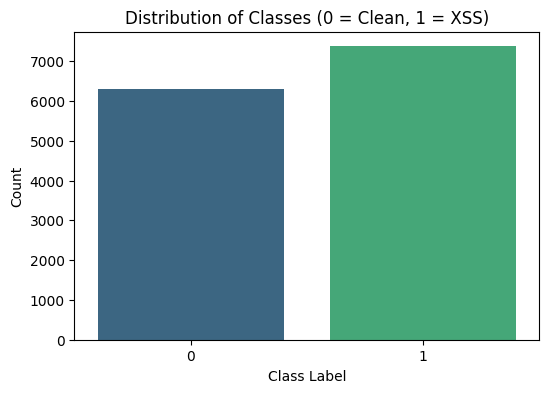

In [ ]:
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df, palette='viridis')
plt.title('Distribution of Classes (0 = Clean, 1 = XSS)')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()


In [ ]:
df=df[df.columns[-2:]]

In [ ]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [ ]:
# Get Sentences data from data frame
sentences=df['Sentence'].values
sentences[1]

'<tt onmouseover="alert(1)">test</tt>'

In [ ]:
print(len(sentences))

13686


In [ ]:
# Convert to ASCII

def convert_to_ascii(sentence):
    sentence_ascii=[]

    for i in sentence:


        """Some characters have values very big e.d 8221 adn some are chinese letters
        I am removing letters having values greater than 8222 and for rest greater
        than 128 and smaller than 8222 assigning them values so they can easily be normalized"""

        if(ord(i)<8222):      # ” has ASCII of 8221

            if(ord(i)==8217): # ’  :  8217
              sentence_ascii.append(134)


            if(ord(i)==8221): # ”  :  8221
                sentence_ascii.append(129)

            if(ord(i)==8220): # “  :  8220
                sentence_ascii.append(130)


            if(ord(i)==8216): # ‘  :  8216
                sentence_ascii.append(131)

            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(132)
            if(ord(i)==8211): # –  :  8211
                sentence_ascii.append(133)


            """
            If values less than 128 store them else discard them
            """
            if (ord(i)<=128):
                    sentence_ascii.append(ord(i))

            else:
                    pass


    zer=np.zeros((10000))

    for i in range(len(sentence_ascii)):
        zer[i]=sentence_ascii[i]

    zer.shape=(100, 100)


#     plt.plot(image)
#     plt.show()
    return zer

In [ ]:
# Preallocate array
arr = np.zeros((len(sentences), 100, 100))

# Convert each sentence to ASCII-based "image"
for i in range(len(sentences)):
    ascii_array = convert_to_ascii(sentences[i])  # shape (100, 100)

    x = np.asarray(ascii_array, dtype='float32')

    # Ensure it is resized properly (though shape is already (100, 100))
    x = cv2.resize(x, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)

    # Normalize
    x /= 128.0

    # Store in dataset array
    arr[i] = x


In [ ]:
print("Input data shape : ", arr.shape)

Input data shape :  (13686, 100, 100)


In [ ]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 100, 100, 1)

In [ ]:
data.shape

(13686, 100, 100, 1)

In [ ]:
y=df['Label'].values

In [ ]:
# Split into train/test data
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data,y, test_size=0.2, random_state=42)

In [ ]:
# import libraries for Making Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization

In [ ]:


# A basic CNN Model
# Number of layers = 11
# Number of Convolutional layer: 3

model=tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64,(3,3), activation=tf.nn.relu, input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,964,737 (26.57 MB)

 Trainable params: 6,964,737 (26.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Stop when validation accuracy > 97
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.97):
            print(" \n Reached 97% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [ ]:
batch_size = 128
num_epoch = 10

# model training
history = model.fit(
    trainX, trainY,
    batch_size=batch_size,
    epochs=num_epoch,
    verbose=1,
    validation_data=(testX, testY),
    callbacks=callbacks  # make sure this variable is defined earlier
)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - accuracy: 0.7520 - loss: 0.5012 - val_accuracy: 0.8952 - val_loss: 0.3650
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8814 - loss: 0.2848 
 Reached 97% + validation accuracy
86/86 ━━━━━━━━━━━━━━━━━━━━ 684s 7s/step - accuracy: 0.8819 - loss: 0.2838 - val_accuracy: 0.9770 - val_loss: 0.0846


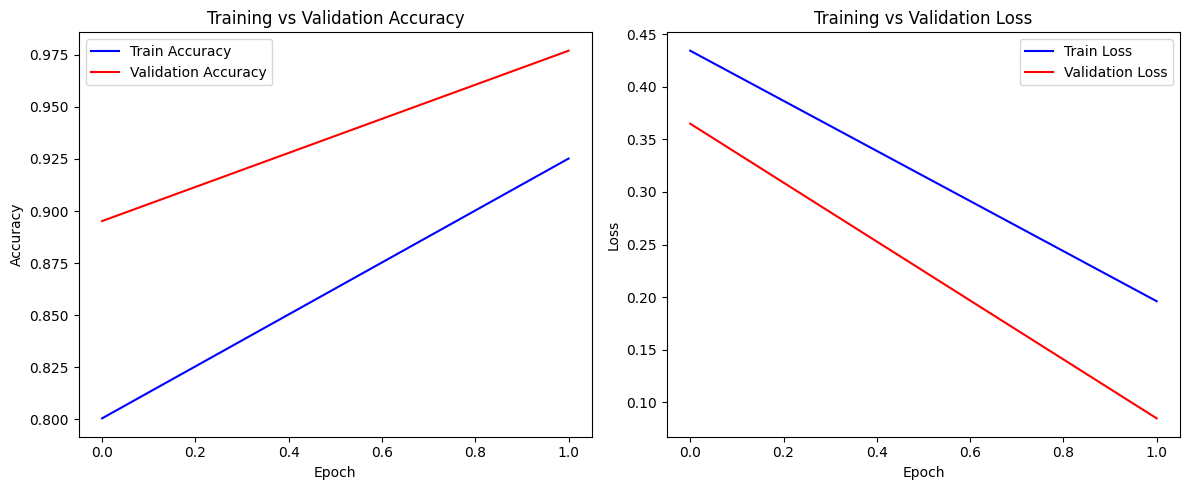

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('xss_detection_model.keras')

In [ ]:
from keras.models import load_model
model = load_model('xss_detection_model.keras', compile=False)

In [ ]:
# predict for test set
pred=model.predict(testX)

86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 493ms/step


In [ ]:
y_pred = (pred > 0.5).astype("int32").flatten()

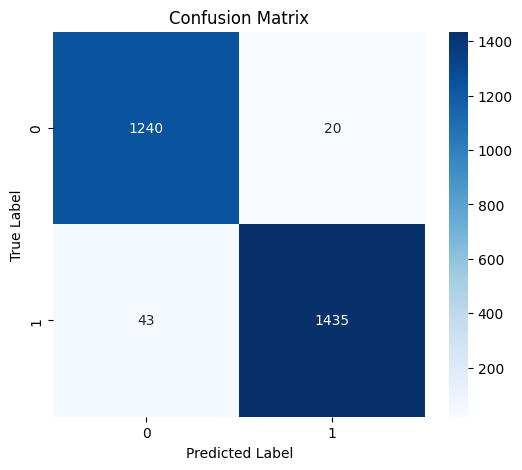

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
cm = confusion_matrix(testY, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(testY, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1260
           1       0.99      0.97      0.98      1478

    accuracy                           0.98      2738
   macro avg       0.98      0.98      0.98      2738
weighted avg       0.98      0.98      0.98      2738



In [ ]:
# Threshold values predicted

for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0

In [ ]:
# Count True predicted and wrong predicted

true=0
false=0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1

print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2675
false prediction ::  63


In [ ]:
attack=0
benign=0
for i in range(len(testY)):
    if testY[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  1478
 Benign data in test set ::  1260


In [ ]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):

    accuracy = (tp+tn) / (tp+tn+fp+fn)

    return accuracy

In [ ]:
# Takes True Positive and false positive
# Returns Precision

def precision_function(tp,fp):

    precision = tp / (tp+fp)

    return precision

In [ ]:


#Takes True Positive and false negative
# Returns Recall

def recall_function(tp,fn):

    recall=tp / (tp+fn)

    return recall



In [ ]:


#Takes true values and predicted
# Returns Accuracy, precision and recall


def confusion_matrix(truth,predicted):

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1

    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)

    return (accuracy,
            precision,
           recall)

In [ ]:
accuracy,precision,recall=confusion_matrix(testY,pred)

In [ ]:
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

 Accuracy : 0.9769905040175311 
 Precision : 0.9862542955326461 
 Recall : 0.9709066305818674


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('xss_detection_model.keras', compile=False)

# Function to convert HTML input to 100x100 ASCII image
def convert_to_ascii_input(sentence):
    sentence_ascii = []

    for i in sentence:
        if ord(i) < 8222:
            if ord(i) == 8217:
                sentence_ascii.append(134)
            elif ord(i) == 8221:
                sentence_ascii.append(129)
            elif ord(i) == 8220:
                sentence_ascii.append(130)
            elif ord(i) == 8216:
                sentence_ascii.append(131)
            elif ord(i) == 8211:
                sentence_ascii.append(133)
            elif ord(i) <= 128:
                sentence_ascii.append(ord(i))

    # Pad or crop to 100x100
    zer = np.zeros((10000))
    for i in range(min(len(sentence_ascii), 10000)):
        zer[i] = sentence_ascii[i]

    zer = zer.reshape((100, 100))
    zer = cv2.resize(zer, (100, 100))
    zer = zer.astype('float32') / 128.0
    return zer.reshape(1, 100, 100, 1)

# Ask for HTML input
html_input = input("Enter an HTML snippet to check for XSS: ")

# Convert and predict
ascii_image = convert_to_ascii_input(html_input)
pred = model.predict(ascii_image)[0][0]

# Output the result
if pred > 0.5:
    print("🔴 XSS Detected (Malicious)")
else:
    print("🟢 Safe (Benign HTML)")

Enter an HTML snippet to check for XSS: hassan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
🟢 Safe (Benign HTML)
